# Analysis of agent-based model

M. Tsvetkova, **The effects of reputation on inequality in network cooperation games**, *Phil. Trans. B* (2021).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sb
import random

import os
import sys

module_path = os.path.abspath(os.path.join('../modules/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ineq import *
from plot import *

NETS = ['random rewiring', 'strategic updates']
NET_DIC = {'rewired-random': 'random rewiring', 'rewired-clustered': 'random rewiring', 
           'strategic-random': 'strategic updates', 'strategic-clustered': 'strategic updates'}

REPUT = [0, 1, 3]
COLORS = {'reputation = 0': '1', 'reputation = 1': 'lightcoral', 'reputation = 3': 'red'}
ORDER_SCATTER = [('random rewiring', 'reputation = 0'), ('random rewiring', 'reputation = 1'),
                ('strategic updates', 'reputation = 0'), ('strategic updates', 'reputation = 1')]


SIMFILE = 'ineq_rep_100_0.15_init_frep_initboost-table.csv' 


### 1. Define data functions

In [2]:
def get_sim_data(dirname):   
    """Read csv file with simulation data and return Pandas dataframe
    with Gini coefficient and average cooperation in last period.
    """
    
    data = pd.read_csv(dirname, header=6)    
    data = data[['network', 'reputation', 
                 '(gini-index-reserve / population-size) * 2', 'mean [action-choice] of turtles']]
    data.columns = ['network', 'reputation', 'gini', 'cooperation']
    data['network'] = [NET_DIC[i.strip('"')] for i in data['network']]
    
    ineq = []
    coop = []
    for n in NETS:
        for r in REPUT:
            subdata = data[(data['network']==n) & (data['reputation']==r)]
            if subdata.empty==False:
                ineq.append(subdata['gini'].values)
                coop.append(subdata['cooperation'].values)

    return ineq, coop


def get_sim_data_agents(dirname):   
    """Read csv file with simulation data, pick an example run for
    reputation = 0 and reputation = 1, and return dictionary with 
    (run_number, reputation) as key and (avg_coopertion, wealth)
    for all agents in final period as value.
    ."""
    
    data = pd.read_csv(dirname, header=6)    
    data = data[['network', 'reputation', '[run number]', '[mean action-history] of turtles', '[wealth] of turtles']]
    data.columns = ['network', 'reputation', 'run', 'cooperativeness', 'wealth']
    # Keep only random networks for consistency
    data = data[(data['network']=='rewired-random') | (data['network']=='strategic-random')]
    data['network'] = [NET_DIC[i.strip('"')] for i in data['network']]
    
    dic = {}
    for n in NETS:
        for r in [0, 1]:
            subdata = data[(data['network']==n) & (data['reputation']==r)]
            run = random.sample(list(subdata['run'].unique()), k=1)[0]
            example = subdata[subdata['run']==run]
            coops = [float(i) for i in example['cooperativeness'].values[0].rstrip(']').lstrip('[').split()]
            wealths = [float(i) for i in example['wealth'].values[0].rstrip(']').lstrip('[').split()]
            dic[(n, 'reputation = ' + str(r))] = (coops, wealths)

    return dic

### 2. Define plotting functions

In [3]:
def custom_axlim(ax, ifylabel=True, ylabel='Gini coefficient', ymax=0.75):
    ax.set_yticks( [i/10 for i in range(int(10*ymax)+1)] )
    ax.set_ylim(0, ymax)
    ax.set_xlim(0.5, 7.1)
    if ifylabel: 
        ax.set_ylabel(ylabel, fontsize=6)
    else:
        ax.set_yticklabels(['             '+str(round(i, 1)) for i in np.linspace(0, ymax-0.05, num = int(ymax/0.1)+1)])


def get_legend_handles():
    rep0 = mpatches.Patch(color='1', label='reputation = 0', ec='k', lw=0.25)
    rep1 = mpatches.Patch(color='lightcoral', label='reputation = 1', ec='k', lw=0.25)
    rep3 = mpatches.Patch(color='red', label='reputation = 3', ec='k', lw=0.25)
    return [rep0, rep1, rep3]


### 3. Plot boxplots for average cooperation and inequality

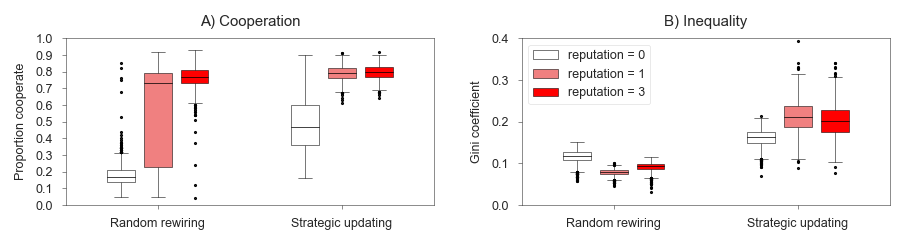

In [4]:
# Initialize figure and axes
init_plot()
f = plt.figure(figsize=(6, 1.6), dpi=150)
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1)

# Set parameters
xlabels = ['Random rewiring', 'Strategic updating'] 
xticks = [1, 2]    
positions = [0.8, 1, 1.2, 
             1.8, 2, 2.2]
colors = 4*['1', 'lightcoral', 'red'] 

# Get data and plot
sim, sim_coop = get_sim_data(SIMFILE)
custom_boxplot(ax1, sim_coop, positions, colors)
custom_boxplot(ax2, sim, positions, colors) 

# Create legend
ax2.legend(handles=get_legend_handles(), ncol=1, loc='upper left')

# Format axes
plt.setp(ax1, xticks=xticks, xticklabels=xlabels)
custom_axlim(ax1, ylabel = 'Proportion cooperate', ymax = 1)
ax1.set_xlim(0.5, 2.5)
ax1.set_title('A) Cooperation')

plt.setp(ax2, xticks=xticks, xticklabels=xlabels)
custom_axlim(ax2, ymax=0.4)
ax2.set_xlim(0.5, 2.5)
ax2.set_title('B) Inequality')

# Save figure
plt.tight_layout(pad=1, w_pad=3, h_pad=0)
plt.show()
f.savefig('../plots/fig_1.pdf', format='pdf', bbox_inches='tight')


### 4. Plot scatter plots for wealth vs. cooperation

<Figure size 432x115.2 with 0 Axes>

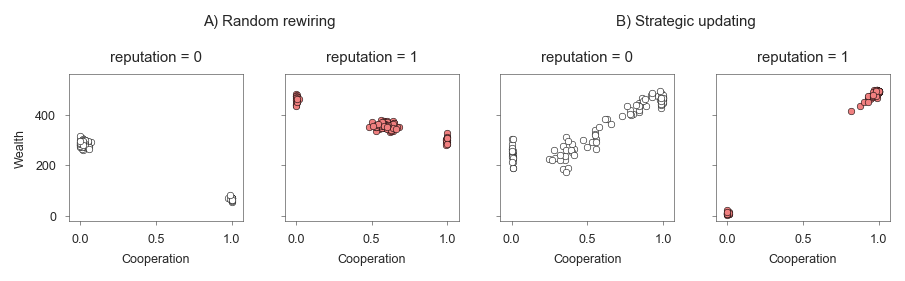

In [5]:
# Set random seed to 2 replicate plots for paper
random.seed(2) 

# Initialize figure and axes
init_plot()
f = plt.figure(figsize=(6, 1.6))
f, axes = plt.subplots(1, 4, figsize=(6, 1.6), dpi=150)

# Get data and plot
cws = get_sim_data_agents(SIMFILE)
for p in range(4):
    data = cws[ORDER_SCATTER[p]]
    axes[p].scatter(data[0], data[1], \
                    color=COLORS[ORDER_SCATTER[p][1]], marker='o', linewidths=0.25, s=10, edgecolors='k')
    axes[p].set_xlim(-0.075, 1.075)
    axes[p].set_ylim(-20, 560)
    axes[p].set_title(ORDER_SCATTER[p][1])
    axes[p].set_xlabel('Cooperation')
    if p==0: 
        axes[p].set_ylabel('Wealth')
    else:
        axes[p].set_yticklabels([])

# Format figure and save
plt.suptitle('A) Random rewiring                                                                    B) Strategic updating'\
             , y=1.1, x=0.53)
plt.tight_layout(pad=1, w_pad=3, h_pad=0)
plt.show()
f.savefig('../plots/fig_2.pdf', format='pdf', bbox_inches='tight')    
